In [1]:
import matplotlib.pyplot as plt
from scipy.special import binom
from functools import partial

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import Clifford
from qiskit.algorithms.minimum_eigensolvers import QAOA as qsQAOA
from qiskit.circuit.library import TwoLocal

from fourier_vqa import *
from experiments_utils import *

import networkx as nx
import os
import dill

from pandas import DataFrame

# Basic example

Here is a brief illustration of how to compute a Fourier series expansion. Likely, you'd like to 

In [2]:
num_qubits = 3

qc = TwoLocal(num_qubits, rotation_blocks='rx', entanglement_blocks='cz', entanglement='linear', reps=1).decompose()
pauli_circuit = PauliCircuit.from_parameterized_circuit(qc)
observable = Pauli('IIZ')

In [3]:
fourier_expansion = FourierExpansionVQA(pauli_circuit, observable)
fourier_expansion.compute()

Δ=100.00% norm absolute=0.12 norm relative=100.00% #nodes=0.00e+00:  33%|████████████████▋                                 | 2/6 [00:00<00:00, 197.41it/s]


In [27]:
-1*(Pauli('I').phase == 2)

0

In [23]:
[node.expectation_value for node in fourier_expansion.complete_nodes]

[0, -1]

In [115]:
qc.draw()

┌──────────┐   ┌──────────┐            
q_0: ┤ Rx(θ[0]) ├─■─┤ Rx(θ[3]) ├────────────
     ├──────────┤ │ └──────────┘┌──────────┐
q_1: ┤ Rx(θ[1]) ├─■──────■──────┤ Rx(θ[4]) ├
     ├──────────┤        │      ├──────────┤
q_2: ┤ Rx(θ[2]) ├────────■──────┤ Rx(θ[5]) ├
     └──────────┘               └──────────┘

In [4]:
np.random.seed(0)
random_angles = np.random.uniform(0, 2*np.pi, size=(qc.num_parameters))
s = Statevector(qc.bind_parameters(random_angles))

In [5]:
cl = s.expectation_value(observable)

In [6]:
cl

0.9339061405733033

In [12]:
from itertools import permutations
for angles in permutations(random_angles):
    fl = fourier_expansion.evaluate_loss_at(angles)
    if np.allclose(fl, cl):
        print('cool')

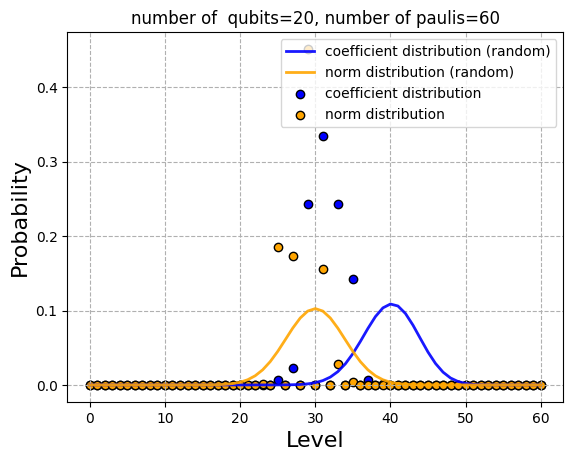

In [34]:
fourier_expansion.stats(only_nonzero=True).plot()

In [5]:
num_qubits = 10

qc = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', reps=3).decompose()
pauli_circuit = PauliCircuit.from_parameterized_circuit(qc)
observable = random_pauli(num_qubits, seed=1)

fourier_expansion = FourierExpansionVQA(pauli_circuit, observable)
fourier_expansion.compute()

Δ=100.00% norm absolute=0.0012 norm relative=100.00% #nodes=0.00e+00:  78%|████████████████████████████████████▍          | 31/40 [00:56<00:16,  1.84s/it]


In [16]:
num_qubits = 5
degree = 4
level = 2

graph = nx.random_regular_graph(degree, num_qubits)
qaoa = QAOA(graph, level)
qaoa_circuit = qaoa.circuit()
observable = QAOA(graph, level).

┌───┐                                                ┌───────────┐»
q_0: ┤ H ├─■───────────■───────────■───────────■──────────┤ Rx(x_0_0) ├»
     ├───┤ │ZZ(z_0_0)  │           │           │          └───────────┘»
q_1: ┤ H ├─■───────────┼───────────┼───────────┼────────────■──────────»
     ├───┤             │           │           │ZZ(z_0_3)   │ZZ(z_0_4) »
q_2: ┤ H ├─────────────┼───────────┼───────────■────────────■──────────»
     ├───┤             │           │ZZ(z_0_2)                          »
q_3: ┤ H ├─────────────┼───────────■───────────────────────────────────»
     ├───┤             │ZZ(z_0_1)                                      »
q_4: ┤ H ├─────────────■───────────────────────────────────────────────»
     └───┘                                                             »
«                                                                   »
«q_0: ──────────────────────────────────────■───────────────────────»
«                             ┌───────────┐ │ZZ(z_1_0)              »
«q_1: ─■───────────■──────────┤ Rx(x_0_1) ├─■───────────────────────»
«      │           │          └───────────┘            ┌───────────┐»
«q_2: ─┼───────────┼────────────■───────────■──────────┤ Rx(x_0_2) ├»
«      │           │ZZ(z_0_6)   │           │ZZ(z_0_8) └───────────┘»
«q_3: ─┼───────────■────────────┼───────────■────────────■──────────»
«      │ZZ(z_0_5)               │ZZ(z_0_7)               │ZZ(z_0_9) »
«q_4: ─■────────────────────────■────────────────────────■──────────»
«                                                                   »
«                                                      ┌───────────┐»
«q_0: ──────────────■───────────■───────────■──────────┤ Rx(x_1_0) ├»
«                   │           │           │          └───────────┘»
«q_1: ──────────────┼───────────┼───────────┼────────────■──────────»
«                   │           │           │ZZ(z_1_3)   │ZZ(z_1_4) »
«q_2: ──────────────┼───────────┼───────────■────────────■──────────»
«     ┌───────────┐ │           │ZZ(z_1_2)                          »
«q_3: ┤ Rx(x_0_3) ├─┼───────────■───────────────────────────────────»
«     ├───────────┤ │ZZ(z_1_1)                                      »
«q_4: ┤ Rx(x_0_4) ├─■───────────────────────────────────────────────»
«     └───────────┘                                                 »
«                                                                   »
«q_0: ──────────────────────────────────────────────────────────────»
«                             ┌───────────┐                         »
«q_1: ─■───────────■──────────┤ Rx(x_1_1) ├─────────────────────────»
«      │           │          └───────────┘            ┌───────────┐»
«q_2: ─┼───────────┼────────────■───────────■──────────┤ Rx(x_1_2) ├»
«      │           │ZZ(z_1_6)   │           │ZZ(z_1_8) └───────────┘»
«q_3: ─┼───────────■────────────┼───────────■────────────■──────────»
«      │ZZ(z_1_5)               │ZZ(z_1_7)               │ZZ(z_1_9) »
«q_4: ─■────────────────────────■────────────────────────■──────────»
«                                                                   »
«                  
«q_0: ─────────────
«                  
«q_1: ─────────────
«                  
«q_2: ─────────────
«     ┌───────────┐
«q_3: ┤ Rx(x_1_3) ├
«     ├───────────┤
«q_4: ┤ Rx(x_1_4) ├
«     └───────────┘

# Random circuits

## Level statistics for fully random circuits

We now collect statistics on the distribution of terms in the dressed Hamiltonian for random circuits.

In [3]:
num_qubits = 30
num_paulis = 25
num_samples = 20

np.random.seed(42)
seeds = np.random.randint(0, 2**32, num_samples)

fourier_stats_samples = []

for seed in tqdm(seeds):
    fourier_computation = FourierExpansionVQA.random(num_qubits, num_paulis, seed)
    # check_admissible=False to get the full expansion of the dressed Hamiltonian
    fourier_computation.compute(check_admissible=False, verbose=False)    
    fourier_stats_samples.append(fourier_computation.stats())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:23<00:00,  4.18s/it]


And visualize it.

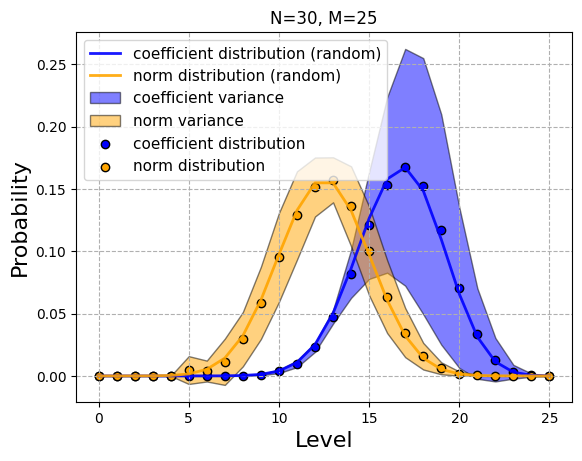

In [4]:
FourierStats.plot_several(fourier_stats_samples)
plt.title(f'N={num_qubits}, M={num_paulis}');
plt.legend(fontsize=11)
plt.savefig('tex/figures/random.png', dpi=1000)

Should be absolete.

## Level statistics for local circuits with random observables

We repeat the computation above, but now only the observale is fully random. Pauli gates are local, bounded by `weight`. The result is that the average distribution of nodes is indeed the same as for the fully random circuits, but with a noticably higher variance.

In [5]:
np.random.seed(42)

num_qubits = 30
num_paulis = 25
num_samples = 100

weigth = 2  # Weight of each local pauli gate.

circuit_seeds = np.random.randint(0, 2**32, num_samples)
observable_seeds = np.random.randint(0, 2**32, num_samples)

circuits = [random_local_pauli_circuit(num_qubits, num_paulis, weigth, seed) for seed in circuit_seeds]
observables = [random_pauli(num_qubits, seed) for seed in observable_seeds]

fourier_stats_samples = []

for seed in tqdm(range(num_samples)):
    seed_circuit, seed_observable = np.random.randint(0, 2**32, 2)
    
    pauli_circuit = random_local_pauli_circuit(num_qubits, num_paulis, weigth, seed_circuit)
    observable = random_pauli(num_qubits, seed_observable)
    
    fourier_computation = FourierExpansionVQA(pauli_circuit, observable)
    # check_admissible=False to get the full expansion of the dressed Hamiltonian
    fourier_computation.compute(check_admissible=False, verbose=False)    
    fourier_stats_samples.append(fourier_computation.stats())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:10<00:00,  3.70s/it]


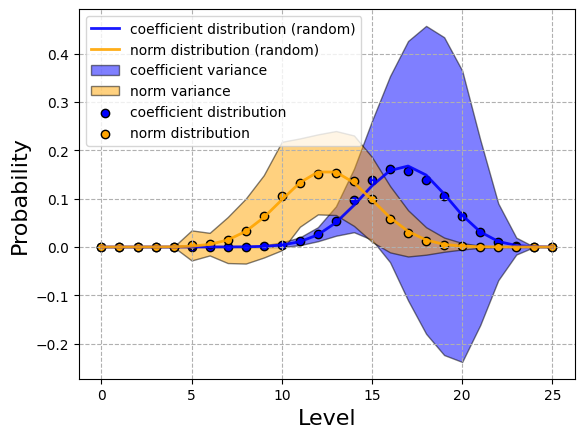

In [6]:
FourierStats.plot_several(fourier_stats_samples)
# plt.title(f'N={num_qubits}, M={num_paulis}');
plt.legend(loc=2);
plt.savefig('tex/figures/random_local_nodes.png', dpi=1000)

## Estimating complexity of the algorithm

Now let us look at how the complexity of the algorithm scales. For this, we use monte-carlso sampling instead of the full computation and also make prunings of the branches based on the expectation values.

In [33]:
np.random.seed(0)

num_samples_monte_carlo = 10**3
num_sample_circuits = 5

max_num_qubits = 100
step_size = 10
qubits = list(range(5, max_num_qubits+1, step_size))
num_computational_nodes = np.zeros((num_sample_circuits, len(qubits)))

for i, num_qubits in tqdm(list(enumerate(qubits))):
    num_paulis = int(np.ceil(num_qubits/np.log2(3/2)))
    seeds = np.random.randint(0, 2**32, num_sample_circuits)
    for j, seed in enumerate(seeds):
        fourier_expansion = FourierExpansionVQA.random(num_qubits, num_paulis, seed)
        num_nodes, _ = fourier_expansion.estimate_node_count_monte_carlo(
            num_samples=num_samples_monte_carlo, 
            check_admissible=True, 
            verbose=False)
        num_computational_nodes[j, i] = num_nodes

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:58<00:00, 11.83s/it]


Now we visualize the data and compare to the theoretical predictions.

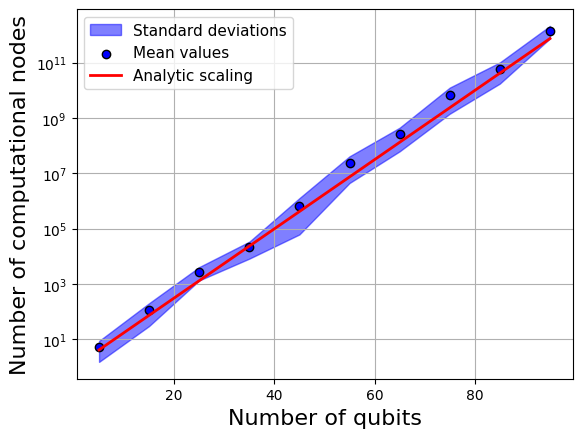

In [36]:
node_means = np.mean(num_computational_nodes, axis=0)
node_variance = np.std(num_computational_nodes, axis=0)

plt.fill_between(qubits, node_means+node_variance, node_means-node_variance, color='blue', alpha=0.5, label='Standard deviations')
plt.scatter(qubits, node_means, color='blue', edgecolors='black', label='Mean values')
plt.plot(qubits, (1.5)**(np.array(qubits)*(1/np.log2(3/2)-1)), color='red', linewidth=2, label='Analytic scaling')
plt.xlabel('Number of qubits', fontsize=16)
plt.ylabel('Number of computational nodes', fontsize=16)
plt.grid()
plt.legend(fontsize=11)
plt.yscale('log')
plt.savefig('tex/figures/random_mc.png')

# QAOA

## Estimating number of computational nodes.

We will use the bound of the reverse lightcone.

In [8]:
def reverse_light_cone_size(d, p):
    if d<2:
        raise ValueError
    elif d==2:
        return int(2*p+2)
    else:
        return int(2*((d-1)**(p+1)-1)/(d-2))

In [8]:
np.random.seed(0)

num_samples_monte_carlo = 10000
num_sample_circuits = 20

max_level = 4
max_degree = 4

num_computational_nodes = np.zeros((num_sample_circuits, max_degree-1, max_level))

for p in tqdm(range(1, max_level+1)):                                         
    for d in range(2, max_degree+1):
        for s in range(num_sample_circuits):
            num_qubits = reverse_light_cone_size(d, p)
            graph = nx.random_regular_graph(d, num_qubits, seed=int(np.random.randint(0, 2**32)))
            qaoa = QAOA(graph, p)

            observables = qaoa.observables()
            observable = observables[np.random.randint(0, len(observables))]

            fourier_expansion = FourierExpansionVQA(PauliCircuit.from_parameterized_circuit(qaoa.circuit()), observable)
            num_nodes, _ = fourier_expansion.estimate_node_count_monte_carlo(
                num_samples=num_samples_monte_carlo, 
                check_admissible=True, 
                verbose=False,
                seed=np.random.randint(0, 2**32))
                                         
            num_computational_nodes[s, d-2, p-1] = num_nodes

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [8:49:03<00:00, 7936.00s/it]


Means.

In [9]:
num_nodes_means = np.mean(np.log10(num_computational_nodes), axis=0)

idx = range(2, max_degree+1)
cols = range(1, max_level+1)
title = 'd \ p'

df_means = DataFrame(num_nodes_means, index=idx, columns=cols)
df_means.style.set_caption('d\p')

,1,2,3,4
2,0.716486,1.477585,3.398900,4.741511
3,1.070407,3.613237,8.630480,17.477228
4,1.374423,5.650029,16.351293,36.643371


Deviations.

In [10]:
num_nodes_deviations = np.std(np.log10(num_computational_nodes), axis=0)

df_std = DataFrame(num_nodes_deviations, index=idx, columns=cols)
df_std.style.set_caption('d\p')

,1,2,3,4
2,0.083975,0.896111,1.686667,2.605148
3,0.142871,0.362477,0.943236,2.236700
4,0.319208,0.454445,1.272623,3.037631


## Distribution of Fourier terms by level

In [9]:
np.random.seed(42)

p = 2
d = 3
num_qubits = reverse_light_cone_size(d, p)

num_samples = 100

fourier_stats_samples_all = []
fourier_stats_samples_nonzero = []
for i in tqdm(range(num_samples)):
    graph = nx.random_regular_graph(d, num_qubits, seed=int(np.random.randint(0, 2**32)))
    qaoa = QAOA(graph, p)

    observables = qaoa.observables()
    observable = observables[np.random.randint(0, len(observables))]
    
    fourier_expansion = FourierExpansionVQA(PauliCircuit.from_parameterized_circuit(qaoa.circuit()), observable)
    fourier_expansion.compute(check_admissible=True, verbose=False)
    fourier_stats_samples_all.append(fourier_expansion.stats(only_nonzero=False))
    fourier_stats_samples_nonzero.append(fourier_expansion.stats(only_nonzero=True))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:52<00:00,  4.13s/it]


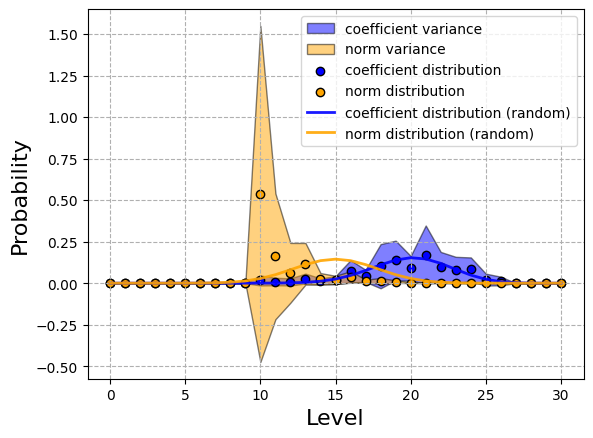

In [10]:
FourierStats.plot_several(fourier_stats_samples_nonzero, plot_random=False, max_level=30)
FourierStats.plot_random(30)
plt.legend();
plt.savefig('tex/figures/qaoa_complexity.png', dpi=1000)

# Hardware-efficient ansatz

In [62]:
np.random.seed(0)

num_samples_monte_carlo = 10**4
num_sample_circuits = 10

num_qubits = 50
M_points = [10]+list(range(100, 600+1, 100))

num_computational_nodes = np.zeros((num_sample_circuits, len(M_points)))

for i, M in tqdm(list(enumerate(M_points))):

    seeds = np.random.randint(0, 2**32, num_sample_circuits)
    for j, seed in enumerate(seeds):
        circuit = brickwall_circuit(num_qubits, M//4)
        observable = random_local_pauli(num_qubits, 2, seed) # Weight=2
        fourier_expansion = FourierExpansionVQA(
            PauliCircuit.from_parameterized_circuit(circuit),
            observable)
        num_nodes, _ = fourier_expansion.estimate_node_count_monte_carlo(
            num_samples=num_samples_monte_carlo, 
            check_admissible=True, 
            verbose=False)
        num_computational_nodes[j, i] = num_nodes

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [1:05:59<00:00, 565.61s/it]


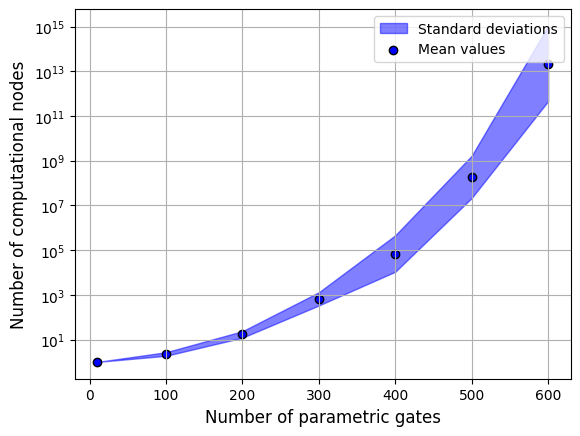

In [63]:
exponents_mean = np.mean(np.log10(num_computational_nodes), axis=0)
exponents_variance = np.std(np.log10(num_computational_nodes), axis=0)

plt.fill_between(M_points, 10**(exponents_mean+exponents_variance), 10**(exponents_mean-exponents_variance), color='blue', alpha=0.5, label='Standard deviations')
plt.scatter(M_points, 10**(exponents_mean), color='blue', edgecolors='black', label='Mean values')
plt.xlabel('Number of parametric gates', fontsize=12)
plt.ylabel('Number of computational nodes', fontsize=12)
plt.grid()
plt.legend()
plt.yscale('log')
plt.savefig('tex/figures/hea.png')

## Distribution of Fourier terms by level

In [11]:
np.random.seed(0)

num_qubits = 50
num_paulis = 304
num_samples = 100

circuit = brickwall_circuit(num_qubits, num_paulis//4)
pauli_circuit = PauliCircuit.from_parameterized_circuit(circuit)

fourier_stats_samples_all = []
fourier_stats_samples_nonzero = []
for _ in tqdm(range(num_samples)):
        observable = random_local_pauli(num_qubits, 2, seed=np.random.randint(0, 2**32)) # Weight=2
        fourier_expansion = FourierExpansionVQA(pauli_circuit, observable)
        fourier_expansion.compute(check_admissible=True, verbose=False)
        fourier_stats_samples_all.append(fourier_expansion.stats(only_nonzero=False))
        fourier_stats_samples_nonzero.append(fourier_expansion.stats(only_nonzero=True))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:08<00:00,  1.88s/it]


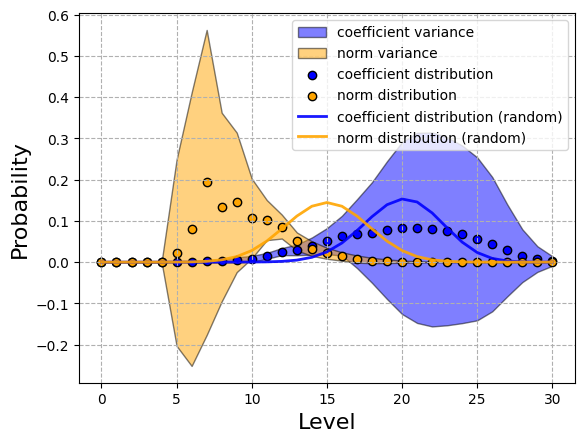

In [12]:
FourierStats.plot_several(fourier_stats_samples_nonzero, plot_random=False, max_level=30)
FourierStats.plot_random(30)
plt.legend();
plt.savefig('tex/figures/HEA_nodes.png', dpi=1000)